# 1. Kalman Filters
The Kalman Filter is a recursive, optimal estimator which can be used to infer some hidden state in a stochastic, dynamic system, over several time steps. This section compares a linear Kalman filter against an Extended Kalman filter.

The Extended Kalman Filter (EKF), is generally very similar to the linear Kalman Filter (KL) in that the prediction and update step are the same. There is an additional step for EKF during the prediction, where either the predicted state or predicted states (both non-linear) are approximated via a first-order or second-order Taylor series expansion about the means of the prediction.

We shall modify the example tutorial from [1] for our comparison.

In [1]:
import numpy as np
from datetime import datetime, timedelta
from ecssupplement import generate_linearish_path, linear_measurement, bearing_range_measurement, linear_kalman_filter, extended_kalman_filter, gaussian_entropy, kl_divergence
from stonesoup.plotter import Plotterly

# Fix our seed
np.random.seed(1991)

Let us generate a linear true path, with different covariances

In [2]:
truth_path_0, transition_model_0, start_time_0 = generate_linearish_path(0, 0)
truth_path_1, transition_model_1, start_time_1 = generate_linearish_path(0.05, 0.05)
truth_path_2, transition_model_2, start_time_2 = generate_linearish_path(1, 1)

### Linear sensor
Let's first create some measurements with a "linear" sensor

In [3]:
measured_path_0, measurement_model_0 = linear_measurement(truth_path_0)
measured_path_1, measurement_model_1 = linear_measurement(truth_path_1)
measured_path_2, measurement_model_2 = linear_measurement(truth_path_2)

### Non-linear sensor
Then let's measure the same path with a "non-linear" sensor path

In [4]:
bearing_path_0, bearing_model_0 = bearing_range_measurement(truth_path_0)
bearing_path_1, bearing_model_1 = bearing_range_measurement(truth_path_1)
bearing_path_2, bearing_model_2 = bearing_range_measurement(truth_path_2)

Now let us apply KF and EKF to both measurement models

In [5]:
track_lin_0 = linear_kalman_filter(transition_model_0, measurement_model_0, measured_path_0, start_time_0)
track_lin_1 = linear_kalman_filter(transition_model_1, measurement_model_1, measured_path_1, start_time_1)
track_lin_2 = linear_kalman_filter(transition_model_2, measurement_model_2, measured_path_2, start_time_2)

track_ekf_0 = extended_kalman_filter(transition_model_0, bearing_model_0, bearing_path_0, start_time_0)
track_ekf_1 = extended_kalman_filter(transition_model_1, bearing_model_1, bearing_path_1, start_time_1)
track_ekf_2 = extended_kalman_filter(transition_model_2, bearing_model_2, bearing_path_2, start_time_2)

track_ekf_lin_1 = extended_kalman_filter(transition_model_1, measurement_model_1, measured_path_1, start_time_1)

In [6]:
# Plot the results
plotter_0 = Plotterly()
plotter_1 = Plotterly()
plotter_2 = Plotterly()

# Plot ground truths
plotter_0.plot_ground_truths(truth_path_0, [0, 2])
plotter_1.plot_ground_truths(truth_path_1, [0, 2])
plotter_2.plot_ground_truths(truth_path_2, [0, 2])

# Plot measured
plotter_0.plot_measurements(measured_path_0, [0, 2], measurements_label="Linear Sensor")
#plotter_1.plot_measurements(measured_path_1, [0, 2], measurements_label="Linear Sensor")
plotter_2.plot_measurements(measured_path_2, [0, 2], measurements_label="Linear Sensor")

plotter_0.plot_measurements(bearing_path_0, [0, 2], measurements_label="Bearing Sensor")
plotter_1.plot_measurements(bearing_path_1, [0, 2], measurements_label="Bearing Sensor")
plotter_2.plot_measurements(bearing_path_2, [0, 2], measurements_label="Bearing Sensor")

# Plot tracking
plotter_0.plot_tracks(track_lin_0, [0, 2], uncertainty=True, track_label="KF Track")
plotter_1.plot_tracks(track_lin_1, [0, 2], uncertainty=True, track_label="KF Track")
plotter_2.plot_tracks(track_lin_2, [0, 2], uncertainty=True, track_label="KF Track")

# Plot non-linear tracking
#plotter_0.plot_tracks(track_ekf_0, [0, 2], uncertainty=True)
plotter_0.plot_tracks(track_ekf_0, [0, 2], uncertainty=True, track_label="EKF Track")
plotter_1.plot_tracks(track_ekf_1, [0, 2], uncertainty=True, track_label="EKF Track")
plotter_2.plot_tracks(track_ekf_2, [0, 2], uncertainty=True, track_label="EKF Track")

In [7]:
plotter_0.fig

In [8]:
plotter_1.fig

In [9]:
plotter_2.fig

Unlike the linear KL, the EKF can work with moderately non-linear sensors and states. In fact, if the states and measurements are both linear and an EKF is applied the filter is identical to a KL.

# 2. Information Measure Development
In this section, we shall return to linear Kalman Filters. In particular, we are interested in its performance under various noise observation levels. We will be using Shannon's entropy and some divergence measures for this comparison.

In [10]:
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

Let us generate a ground truth

In [11]:
q = 0.1
true_path, transition_model, start_time =  generate_linearish_path(q, q)

Then we shall create 3 different linear sensors, of various noise levels

In [12]:
measured_0, measure_model_0 = linear_measurement(true_path, w=1)
measured_1, measure_model_1 = linear_measurement(true_path, w=5)
measured_2, measure_model_2 = linear_measurement(true_path, w=10)

Now do the Kalman Filters

In [13]:
track_0 = linear_kalman_filter(transition_model, measure_model_0, measured_0, start_time)
track_1 = linear_kalman_filter(transition_model, measure_model_1, measured_1, start_time)
track_2 = linear_kalman_filter(transition_model, measure_model_2, measured_2, start_time)

### Analysis
Let us observe the Shannon entropies for the Kalman outputs. As both the state and measure are modelled as linear Gaussian, the tracks are also Gaussian. The *differential* entropy for a multivariate Gaussian is given by [2]

$$
H(x) = \frac{d}{2} ln(2\pi) + \frac{1}{2} ln{|\Sigma|} + \frac{1}{2} n
$$

An brief inspection of this equation implies we should expect the differential entropy to be higher for Gaussian distributions with higher covariances.

Now let us plot the entropies of the computed tracks.

In [14]:
entropy_0 = [gaussian_entropy(state) for state in track_0.states]
entropy_1 = [gaussian_entropy(state) for state in track_1.states]
entropy_2 = [gaussian_entropy(state) for state in track_2.states]

In [15]:
N = len(measured_0)

kl_01 = []
for i in range(N):
    tmp = kl_divergence(measured_0[i], measured_1[i])
    kl_01.append(tmp)

kl_10 = []
for i in range(N):
    tmp = kl_divergence(measured_1[i], measured_0[i])
    kl_10.append(tmp)

kl_02 = []
for i in range(N):
    tmp = kl_divergence(measured_0[i], measured_2[i])
    kl_02.append(tmp)

kl_20 = []
for i in range(N):
    tmp = kl_divergence(measured_2[i], measured_0[i])
    kl_20.append(tmp)

kl_12 = []
for i in range(N):
    tmp = kl_divergence(measured_1[i], measured_2[i])
    kl_12.append(tmp)

kl_21 = []
for i in range(N):
    tmp = kl_divergence(measured_2[i], measured_1[i])
    kl_21.append(tmp)


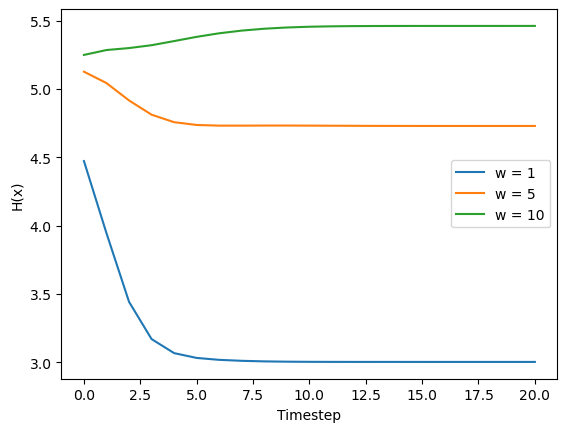

In [16]:
plt.plot(entropy_0, label="w = 1")
plt.plot(entropy_1, label="w = 5")
plt.plot(entropy_2, label="w = 10")
plt.xlabel("Timestep")
plt.ylabel("H(x)")
plt.legend()
plt.show()

As shown above, the tracks with a lower noise level reveal a lower entropy overall.

Now let us turn our attention to the divergence between the sensors in each state. Specifically we wish to compute the Kullback–Leibler divergence between the sensors.

The Kullback–Leibler divergence is given by the following:

$$
KL = \frac{1}{2} (ln(\frac{|\Sigma_1|}{\Sigma_0}) - d + tr(\Sigma_1^{-1}\Sigma_0) + (\mathbf{\mu}_1 - \mathbf{\mu}_0)^T \Sigma_1^{-1}(\mathbf{\mu}_1 - \mathbf{\mu}_0) )
$$

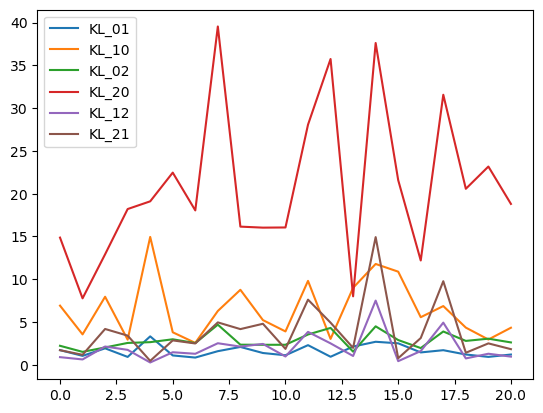

In [17]:
plt.plot(kl_01, label="KL_01")
plt.plot(kl_10, label="KL_10")
plt.plot(kl_02, label="KL_02")
plt.plot(kl_20, label="KL_20")
plt.plot(kl_12, label="KL_12")
plt.plot(kl_21, label="KL_21")
plt.legend()
plt.show()

As observed in the above figure, we notice that the Kullback–Leibler divergence between sensor 0 and sensor 2 are much higher than that of all other divergences. This is not that surprising given that these two sensors have the highest deviation in noise covariances.

## References

[1] https://stonesoup.readthedocs.io/en/latest/auto_tutorials/01_KalmanFilterTutorial.html#sphx-glr-auto-tutorials-01-kalmanfiltertutorial-py
[2] https://statproofbook.github.io/P/mvn-dent